# **Safaricom Suspicious Review Detection using Machine Learning**

This notebook develops a machine learning model to detect suspicious reviews in a multilingual setting (English, Swahili, and Sheng).

The goal is to identify potentially deceptive or anomalous reviews using;
- Textual features
- Behavioural signals
- Rating–sentiment inconsistencies
- Structural writing patterns

The approach follows a structured machine learning workflow from data understanding to model evaluation.

## **1.0 Business Understanding**
### Background and Context
Digital platforms increasingly rely on user-generated reviews as a primary source of public feedback and reputation signaling. For high-impact applications such as Safaricom and M-Pesa, Google Play Store reviews play a critical role in shaping user perception, influencing download decisions, and reinforcing brand trust.

Safaricom and M-Pesa are foundational digital services in Kenya, supporting communication, mobile financial transactions, savings, and daily economic activity for millions of users. Because of their scale and strategic importance, even small shifts in public sentiment or rating perception can have significant reputational and commercial implications.

However, online review ecosystems are inherently vulnerable to manipulation and irregular activity. Suspicious reviews may arise from:
- Coordinated campaigns intended to artificially inflate or deflate ratings.
- Automated or bot-generated repetitive content.
- Emotionally exaggerated feedback that does not align with rating behavior.
- Structurally anomalous posting patterns.
- Low-effort template reviews that distort overall sentiment signals.

Such reviews can create several risks:
- Artificial inflation or suppression of average ratings.
- Misleading signals for prospective users.
- Distortion of genuine customer feedback insights.
- Increased workload for moderation teams.
- Reputational exposure to coordinated manipulation.

At the same time, suspicious reviews typically represent only a small proportion of total reviews, creating a highly imbalanced detection problem. This makes traditional classification approaches insufficient without careful design, evaluation, and threshold optimization.

To address this challenge, this project develops a hybrid suspicious review detection framework that combines:
- Textual analysis of review content,
- Behavioural and structural indicators,
- Optimized decision thresholds to prioritize high-confidence detection.

### Problem Statement
Safaricom and M-Pesa Play Store reviews serve as a key public signal of product quality, reliability, and user satisfaction. These reviews influence potential users, guide product improvement decisions, and shape overall brand perception. However, the open nature of online review platforms makes them susceptible to suspicious or potentially inauthentic activity.

The core problem is to design a reliable, scalable and precision-focused system capable of detecting suspicious Safaricom and M-Pesa Play Store reviews using both textual and behavioural indicators in a highly imbalanced environment.

The solution must balance two competing priorities:
1. Detecting a meaningful proportion of suspicious reviews (recall) 
2. Minimizing false alarms to ensure practical deployment (precision).

This project addresses this problem by developing and evaluating a hybrid machine learning framework that integrates textual analysis with behavioural feature engineering and threshold optimization to produce high-confidence suspicious review detection.

### Main Objective
To build a machine learning model that can automatically detect suspicious reviews from Safaricom and M-Pesa Google Play Store, enabling high-confidence flagging of potentially inauthentic reviews for review monitoring and moderation.

#### Specific Objectives
The specific objectives of the project are;
 1. To engineer textual and behavioral features to support suspicious review detection.
 2. To define and label suspicious reviews in the Safaricom and M-Pesa datasets as targets for model training.
 3. To train, evaluate and refine models for accurately detecting high-confidence suspicious reviews.

#### Research Questions
This project seeks to answer the following research questions;
 1. How to effectively engineer textual and behavioral features for capturing patterns that indicate suspicious reviews?
 2. How accurately do the labeled suspicious reviews represent actual suspicious or potentially fake activity in the dataset?
 3. How well do the trained models detect suspicious reviews, and does refining thresholds improve the reliability of high-confidence predictions?

### Data Source 
Data was scraped using google-play-scraper to get data from google play store for;
•	Safaricom App
•	M-Pesa App

*Each record includes;*
•	Review text
•	Rating (1–5 stars)
•	Timestamp
•	App version
•	Helpful votes

In [66]:
# Importing libraries
import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib.pyplot inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, 
accuracy_score, precision_recall_curve, roc_auc_score, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


UsageError: Line magic function `%matplotlib.pyplot` not found.


### Load and inspect the dataset


In [2]:
df = pd.read_csv("./Data/safaricom_reviews_multilingual.csv")
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns)

print("\nFirst 5 rows:")
df.head()

Shape: (32000, 12)

Columns:
Index(['app_name', 'app_id', 'reviewId', 'userName', 'review_text', 'rating',
       'date', 'thumbs_up', 'version', 'lang_detected', 'is_code_mixed',
       'is_sheng_like'],
      dtype='object')

First 5 rows:


,app_name,app_id,reviewId,userName,review_text,rating,date,thumbs_up,version,lang_detected,is_code_mixed,is_sheng_like
0,M-PESA,com.safaricom.mpesa.lifestyle,f6df29d5-b57d-4324-be85-89abeaa3447a,cynthia wairimu,best,5,2026-02-11 23:31:13,0,3.5.9,unknown,False,False
1,M-PESA,com.safaricom.mpesa.lifestyle,d5067a38-f2c0-4e3d-b1c7-9e84a59adc4a,Chepchir Adhis,😔,1,2026-02-11 23:05:42,0,NaN,unknown,False,False
2,M-PESA,com.safaricom.mpesa.lifestyle,68a05147-4b49-4eb2-85c3-5d081bd0ae1b,Charles Muchiri,Better option this vantine. 18yrs old day to d...,5,2026-02-11 22:33:17,0,3.5.9,en,False,False
3,M-PESA,com.safaricom.mpesa.lifestyle,b75a78c7-ae4b-4cf8-9a4c-108f9bb9498f,GODFREY ODINGA,Amazing,5,2026-02-11 21:38:06,0,3.5.9,unknown,False,False
4,M-PESA,com.safaricom.mpesa.lifestyle,c962c8a9-6041-46e9-8325-49b699e6f645,Joy Chepkemboi,Its so easy to use at your comfort and you don...,1,2026-02-11 21:35:03,0,3.5.9,en,False,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   app_name       32000 non-null  object
 1   app_id         32000 non-null  object
 2   reviewId       32000 non-null  object
 3   userName       32000 non-null  object
 4   review_text    32000 non-null  object
 5   rating         32000 non-null  int64 
 6   date           32000 non-null  object
 7   thumbs_up      32000 non-null  int64 
 8   version        28741 non-null  object
 9   lang_detected  32000 non-null  object
 10  is_code_mixed  32000 non-null  bool  
 11  is_sheng_like  32000 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 2.5+ MB


#### Data Understanding
The dataset contains user reviews collected from a mobile application platform. Each row represents a single user review.

The dataset contains 32000 rows and 12 columns;
* `app_name`  - name of the mobile application.
* `reviewId`  - unique identifier assigned to each review.  
* `userName`  - username of the individual who posted the review.     
* `review_text` - The actual textual content written by the user.
* `rating` - A numerical score given by the user, typically ranging from 1 to 5.       
* `date`  - Date the review was posted.         
* `thumbs_up` - The number of users who marked the review as helpful.
* `version`  - The version of the application at the time the review was posted.    
* `lang_detected`  - The automatically detected language of the review text.
* `is_code_mixed` - A binary indicator showing whether the review contains more than one language.    
* `is_sheng_like`  - A binary indicator showing whether the review contains Sheng-like linguistic patterns.  

## **2.0 Data Cleaning and Preprocessing**
### Goals 
1. Handle missing values
2. Check for duplicated 
3. Clean review_text (remove URLs/noise, keep emojis + Sheng slang)
4. Convert date → datetime
5. Create robust text representations for:
    - modeling (text_clean)
    - duplicates (text_norm)

### 2.1 Missing Values
Fill missing values for completeness.

In [4]:
# Null values
df.isnull().sum().sort_values(ascending=False)

version          3259
is_sheng_like       0
is_code_mixed       0
lang_detected       0
thumbs_up           0
date                0
rating              0
review_text         0
userName            0
reviewId            0
app_id              0
app_name            0
dtype: int64

In [5]:
#  fill Missing values version 
df["version"] = df["version"].fillna("unknown_version")

### 2.2 Duplicate Analysis
Check for duplicates in the dataset

In [6]:
# Duplicated rows
df.duplicated().sum()

0

In [7]:
# Duplicates by revewID
df.duplicated(subset='reviewId').sum()

0

In [8]:
df.duplicated(subset='userName').sum()

1778

In [9]:
# Filter the dataframe for all duplicated user names
# Sort by userName so the duplicates appear together
duplicates_df = df[df.duplicated(subset='userName', keep=False)].sort_values(by='userName')

# 3. View the first few rows
print(duplicates_df[['userName', 'review_text', 'date']].tail(10))

               userName                                        review_text  \
11061      sylas letozy                                               best   
17839      sylas letozy  your services people are complaining currently...   
16420     victor lunale                                 Excellent to first   
2596      victor lunale                                       I Crown 👑 it   
23268  zigwazack zakayo                                              excel   
1867   zigwazack zakayo                      it's good to transact with it   
24844             ɪʙʀᴀʜ                 The app is really great.Love it❤❤❤   
3444              ɪʙʀᴀʜ                           Amazing transparent app🥰   
26838      عابدول ماجيد                                          Amazing 😄   
11425      عابدول ماجيد                                  Best ... reliable   

                      date  
11061  2025-06-02 14:48:51  
17839  2025-09-19 18:17:56  
16420  2026-01-12 11:04:31  
2596   2025-12-17 15:07:4

### 2.3 Text cleaning for the **review_text** column.
Before modelling, the review text is cleaned and normalized.

Steps include:
- Lowercasing
- Removing unnecessary symbols
- Preparing text for feature extraction

Care was taken not to aggressively remove linguistic variations, since the dataset is multilingual.


In [10]:
# --- Text cleaning ---
def clean_text_keep_emojis(text: str) -> str:
    """
    Light cleaning:
    - remove URLs
    - remove control whitespace
    - normalize spaces
    - keep emojis + Sheng slang intact
    """
    if not isinstance(text, str):
        return ""
    t = text.strip()
    t = re.sub(r"http\S+|www\.\S+", " ", t)      # remove urls
    t = re.sub(r"[\r\n\t]+", " ", t)            # normalize whitespace
    t = re.sub(r"\s{2,}", " ", t)               # collapse spaces
    return t.strip() 

df["text_clean"] = df["review_text"].map(clean_text_keep_emojis)

# normalized form for duplication detection
df["text_norm"] = (
    df["text_clean"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .fillna("")
)

df[["review_text", "text_clean", "text_norm", "lang_detected", "is_code_mixed", "is_sheng_like"]].head(10)

,review_text,text_clean,text_norm,lang_detected,is_code_mixed,is_sheng_like
0,best,best,best,unknown,False,False
1,😔,😔,😔,unknown,False,False
2,Better option this vantine. 18yrs old day to d...,Better option this vantine. 18yrs old day to d...,better option this vantine. 18yrs old day to d...,en,False,False
3,Amazing,Amazing,amazing,unknown,False,False
4,Its so easy to use at your comfort and you don...,Its so easy to use at your comfort and you don...,its so easy to use at your comfort and you don...,en,False,False
5,good 👍,good 👍,good 👍,unknown,False,False
6,😊👍,😊👍,😊👍,unknown,False,False
7,very helpful and reduces a lot of work in term...,very helpful and reduces a lot of work in term...,very helpful and reduces a lot of work in term...,en,False,False
8,its good and nice app,its good and nice app,its good and nice app,en,False,False
9,Great,Great,great,unknown,False,False


The text has now been normalized and cleaned.
This ensures:
- Consistency across reviews
- Reduced noise
- Better quality feature extraction during modelling

### 2.3 Text length 
Create columns for number or characters and text length
- Number of words in the text

In [11]:
df["char_length"] = df["text_norm"].str.len()


In [12]:
# column for character_length
df["char_length"] = df["text_norm"].str.len()

# word_count column
df['word_count'] = df['review_text'].fillna('').apply(lambda x: len(str(x).split()))

# top 5 longest reviews
top_5_longest = df.nlargest(5, 'word_count')
print(top_5_longest[['userName', 'word_count', 'review_text', 'rating']])

                 userName  word_count  \
30859       albanus kioko         140   
5656   Jeane Ng'eno-Tarus          96   
6291         new Begining          96   
7387           Jewel Hope          96   
19976       Kennedy Kamau          96   

                                             review_text  rating  
30859  Fa CJ HH cc H BB see bvase boo HH v saa nuke b...       2  
5656   I was looking for how to hide or remove the fu...       3  
6291   I'm trying to withdraw from PayPal but the app...       1  
7387   I have used this app for so long, and it has a...       1  
19976  I love the app i use it on a daily basis but a...       4  


In [13]:
# duplicated texts
df[df['text_clean'].duplicated(keep=False)]['text_norm'].value_counts().head(10)

good         2511
excellent     965
nice          593
best          527
great         440
perfect       351
good app      350
awesome       305
very good     300
nice app      296
Name: text_norm, dtype: int64

There is a large number of low information reviews that do not provide actionable feedback while inflating the reviews.

### 2.4 Timestamp processing
Converting date column from object to date time

In [14]:
# Date column conversion
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df['date'].min(), df['date'].max()

(Timestamp('2023-08-26 07:44:28'), Timestamp('2026-02-11 23:31:13'))

In [15]:
# The dates range from 2023-08 to 2026-02

### 2.5. Refine the column language detected

One word reviews the language detected column missed their language description. The aim is to improve the lang_detected column.

In [16]:
# The number of items for each language
df['lang_detected'].value_counts()


en         16683
unknown     7626
other       7527
sw           164
Name: lang_detected, dtype: int64

In [17]:
# Define common keywords for recovery
en_keywords = {'good', 'best', 'great', 'cool', 'excellent', 'nice', 'awesome', 'amazing', 'perfect', 'love', 'app', 'slow', 'fair', 'enough'}
sw_keywords = {'poa', 'safi', 'mzuri', 'mbaya', 'shida', 'asante', 'hakuna', 'wapi', 'fiti', 'vizuri'}

def refine_language(row):
    current = row['lang_detected']
    # If the text is short and labeled unknown/other, check keywords
    if current in ['unknown', 'other']:
        words = set(row['text_norm'].split())
        if words.intersection(en_keywords):
            return 'en'
        if words.intersection(sw_keywords):
            return 'sw'
    return current

df['lang_refined'] = df.apply(refine_language, axis=1)
df[["review_text", "text_norm", "lang_detected", "lang_refined"]].head(10)
print(df['lang_refined'].value_counts())

en         26799
other       2987
unknown     2020
sw           194
Name: lang_refined, dtype: int64


In [18]:
# Filtering the dataframe for 'unknown' refined language
unknown_reviews = df[df['lang_refined'] == 'unknown']

# Displaying the count and the first 20 rows of relevant columns
print(f"Total reviews still labeled 'unknown': {len(unknown_reviews)}")

# Using .head(20) to see a sample
unknown_reviews[['review_text', 'text_norm', 'rating', 'lang_detected', 'lang_refined']].head()

Total reviews still labeled 'unknown': 2020


,review_text,text_norm,rating,lang_detected,lang_refined
1,😔,😔,1,unknown,unknown
6,😊👍,😊👍,5,unknown,unknown
44,dope,dope,4,unknown,unknown
58,𝕖𝕒𝕤𝕪 𝕥𝕠 𝕒𝕔𝕔𝕖𝕤𝕤,𝕖𝕒𝕤𝕪 𝕥𝕠 𝕒𝕔𝕔𝕖𝕤𝕤,5,unknown,unknown
61,👍👍👍,👍👍👍,5,unknown,unknown


In [19]:
# Filtering the dataframe for 'unknown' refined language
other_reviews = df[df['lang_refined'] == 'other']

# Displaying the count and the first 20 rows of relevant columns
print(f"Total reviews still labeled 'other': {len(other_reviews)}")

# Using .head(20) to see a sample
other_reviews[['review_text', 'text_norm', 'rating', 'lang_detected', 'lang_refined']].head(20)

Total reviews still labeled 'other': 2987


,review_text,text_norm,rating,lang_detected,lang_refined
11,Easy to navigate,easy to navigate,5,other,other
18,safaricom mpesa pamoja milele,safaricom mpesa pamoja milele,5,other,other
68,faster and save,faster and save,5,other,other
107,i like it,i like it,4,other,other
108,I like it,i like it,5,other,other
112,it's taking long to update 😩,it's taking long to update 😩,5,other,other
121,Sometimes it takes time to make payment,sometimes it takes time to make payment,3,other,other
136,disturbing always,disturbing always,1,other,other
141,its just loading,its just loading,1,other,other
179,outstanding.,outstanding.,5,other,other


## **3.0 Exploratory Data Analysis (EDA)**
Goals
1. Rating distribution
2. Language distribution
3. Review frequency over time
4. Term Frequency
5. Weak labelling
6. Sentiment rating Deception


### 3.1 Rating Distribution

In [20]:
rating_counts = df['rating'].value_counts().sort_index()
print(rating_counts)


1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64


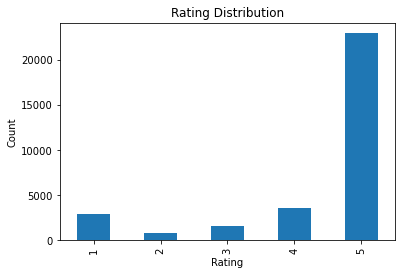

1     2954
2      807
3     1632
4     3625
5    22982
Name: rating, dtype: int64
Share of 5*: 0.7181875


In [21]:
# Bar graph for rating distribution
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print(rating_counts)
print("Share of 5*:", (df["rating"] == 5).mean())

The rating is skewed towards 5 stars where the 5 stars are dominant.

The dataset exhibits a heavily right-skewed rating distribution, with 71.8% of reviews being 5-stars.

### 3.2 Language distribution

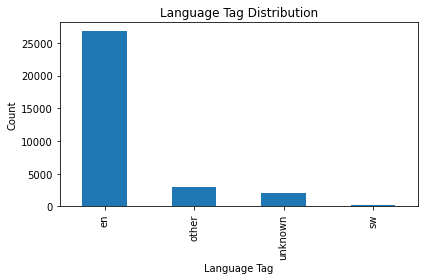

en         26799
other       2987
unknown     2020
sw           194
Name: lang_refined, dtype: int64
Code-mixed share: 0.0005
Sheng-like share: 0.0029375


In [22]:
# Plot of language distribution
lang_counts = df["lang_refined"].value_counts()

plt.figure()
lang_counts.plot(kind="bar")
plt.title("Language Tag Distribution")
plt.xlabel("Language Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(lang_counts)
print("Code-mixed share:", df["is_code_mixed"].mean())
print("Sheng-like share:", df["is_sheng_like"].mean())

### 3.3 Review word length distribution

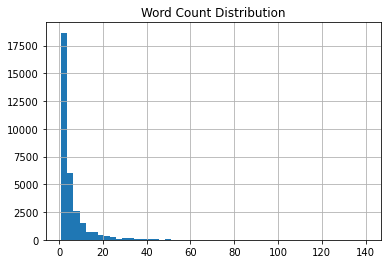

In [23]:
# Plot of word count distribution
df["word_count"].hist(bins=50)
plt.title("Word Count Distribution")
plt.show()

In [24]:
# There are many short reviews between 1-2 words with a skew towards short reviews

### 3.4 Burst Activity Visualization


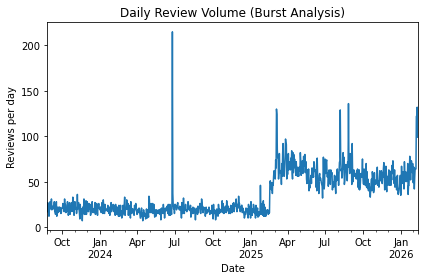

count    901.000000
mean      35.516093
std       23.011906
min        7.000000
25%       18.000000
50%       24.000000
75%       54.000000
max      215.000000
Name: n, dtype: float64
Top spike days:
 date
2024-06-25    215
2025-08-27    136
2026-02-10    132
2025-03-05    130
2025-08-07    129
Name: n, dtype: int64


In [25]:
#Plot of review frequency over time
daily = df.set_index("date").resample("D").size().rename("n")

plt.figure()
daily.plot()
plt.title("Daily Review Volume (Burst Analysis)")
plt.xlabel("Date")
plt.ylabel("Reviews per day")
plt.tight_layout()
plt.show()

print(daily.describe())
print("Top spike days:\n", daily.nlargest(5))

In [26]:
# One extreme outlier is observed, where daily reviews increased dramatically compared to surrounding periods. 
# Such anomalies indicate coordinated review behavior, product-related events, or automated posting activity.

Mark burst days using a percentile threshold

In [27]:
p97 = daily.quantile(0.97)   # top 3% days
burst_days = set(daily[daily >= p97].index.date)

df["is_burst_day"] = df["date"].dt.date.isin(burst_days)

print("Burst threshold (97th percentile):", p97)
print("Burst-day reviews:", df["is_burst_day"].sum())
print("Burst-day share:", df["is_burst_day"].mean())

Burst threshold (97th percentile): 78.0
Burst-day reviews: 2885
Burst-day share: 0.09015625


### 3.5 Term frequancy
 - Determine the frequent code mixed words
 - Determine frequent words combined

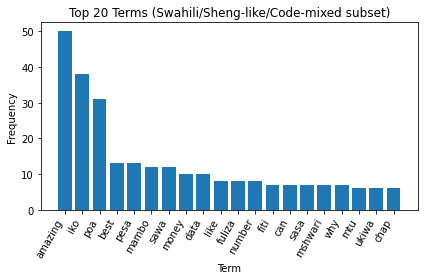

[('amazing', 50),
 ('iko', 38),
 ('poa', 31),
 ('best', 13),
 ('pesa', 13),
 ('mambo', 12),
 ('sawa', 12),
 ('money', 10),
 ('data', 10),
 ('like', 8),
 ('fuliza', 8),
 ('number', 8),
 ('fiti', 7),
 ('can', 7),
 ('sasa', 7),
 ('mshwari', 7),
 ('why', 7),
 ('mtu', 6),
 ('ukiwa', 6),
 ('chap', 6)]

In [28]:
# Stopwords
stop_en = set("the a an and or is are was were to of in for on at it this that i you we they he she my our your app mpesa m-pesa safaricom".split())
stop_sw = set("na ya kwa ni si hii hiyo sana pia tu nilikuwa mimi wewe yeye sisi wao".split())

# function for top terms
def top_terms(text_series, n=20):
    c = Counter()
    for t in text_series.dropna():
        words = re.findall(r"[a-zA-ZÀ-ÿ']+", t.lower())
        for w in words:
            if len(w) <= 2:
                continue
            if w in stop_en or w in stop_sw:
                continue
            c[w] += 1
    return c.most_common(n)

# focus on Swahili + Sheng-like + code-mixed buckets
subset = df[(df["lang_refined"] == "sw") | (df["is_sheng_like"] == True) | (df["is_code_mixed"] == True)]
top20 = top_terms(subset["text_clean"], n=20)

terms, freqs = zip(*top20) if top20 else ([], [])

plt.figure()
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(terms)), terms, rotation=60, ha="right")
plt.title("Top 20 Terms (Swahili/Sheng-like/Code-mixed subset)")
plt.xlabel("Term")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

top20

#### Top frequent phrases

In [29]:
# Top most important  words by context
# Initialize the translator
vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1,2))

# Fit transform
X = vectorizer.fit_transform(df["text_clean"])
print(vectorizer.get_feature_names())

['and', 'app', 'best', 'easy', 'excellent', 'for', 'good', 'great', 'is', 'it', 'nice', 'the', 'the app', 'the best', 'this', 'to', 'to use', 'use', 'very', 'you']


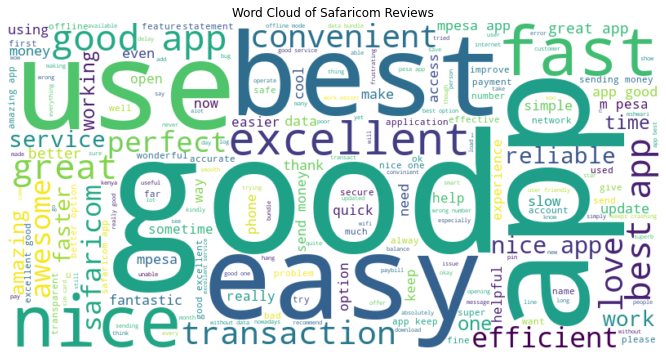

In [30]:
# Wordcloud with the most common words
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df["text_norm"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Safaricom Reviews")
plt.show()

## **4.0 Heuristic Weak Labeling (is_suspicious)**
### 4.1 Multilingual lexicon-based sentiment score (English + Swahili + Sheng + emojis)

In [31]:
# English markers
positive_en = set("good great best amazing awesome excellent love loved nice perfect works working helpful fast reliable".split())
negative_en = set("bad worst terrible hate hated slow bug bugs buggy crash crashes crashing error errors fail failed failing useless poor disappointed disappointing scam".split())

# Swahili markers
positive_sw = set(["nzuri", "safi", "bomba", "vizuri", "bora", "napenda"])
negative_sw = set(["mbaya", "mbovu", "kosa", "makosa", "tatizo", "matatizo", "inakwama", "haifanyi", "haiwezi"])

# Sheng markers
positive_sh = set(["poa", "noma", "fresh", "safi", "kali", "fiti"])
negative_sh = set(["mbaya", "mbovu", "imekwama", "imeshindwa", "imeniboo"])

# Emoji markers
pos_emojis = {"😀","😃","😄","😁","😍","😊","👍","❤️","❤","💯","🔥","🎉"}
neg_emojis = {"😡","😠","😤","😭","😢","👎","💔","😔","🤬"}

# Words negating the positive markers
negation_words = {"not", "no", "never", "hakuna", "sio", "si"}


# --- Improved normalized sentiment ---
def sentiment_score_improved(text: str) -> float:
    if not isinstance(text, str):
        return 0.0

    t = text.lower()
    words = re.findall(r"[a-zA-ZÀ-ÿ']+", t)

    if len(words) == 0:
        return 0.0

    score = 0
    negate = False

    for w in words:
        if w in negation_words:
            negate = True
            continue

        val = 0
        if w in positive_en or w in positive_sw or w in positive_sh:
            val = 1
        elif w in negative_en or w in negative_sw or w in negative_sh:
            val = -1

        if negate:
            val = -val
            negate = False

        score += val

    # emoji sentiment
    for e in pos_emojis:
        if e in text:
            score += 1
    for e in neg_emojis:
        if e in text:
            score -= 1

    # normalize to [-1, 1] approximately
    return score / len(words)

# Apply sentiment
df["sent_score_norm"] = df["text_norm"].map(sentiment_score_improved)

# Scale rating to [-1, 1]
df["rating_scaled"] = (df["rating"] - 3) / 2

# Strong mismatch feature
df["rating_sentiment_mismatch"] = (
    df["rating_scaled"] - df["sent_score_norm"]
) ** 2

# Sentiment intensity (often strong signal)
df["abs_sentiment_strength"] = df["sent_score_norm"].abs()

print("Sentiment features created.")

Sentiment features created.


In [32]:
# Feature Engineering
# --- Improved normalized sentiment ---
def sentiment_score_improved(text: str) -> float:
    if not isinstance(text, str):
        return 0.0
    t = text.lower()
    words = re.findall(r"[a-zA-ZÀ-ÿ']+", t)

    if len(words) == 0:
        return 0.0
    score = 0
    negate = False

    for w in words:
        if w in negation_words:
            negate = True
            continue
        val = 0
        if w in positive_en or w in positive_sw or w in positive_sh:
            val = 1
        elif w in negative_en or w in negative_sw or w in negative_sh:
            val = -1
        if negate:
            val = -val
            negate = False
        score += val

    # emoji sentiment
    for e in pos_emojis:
        if e in text:
            score += 1
    for e in neg_emojis:
        if e in text:
            score -= 1

    # normalize to [-1, 1] approximately
    return score / len(words)

# Apply sentiment
df["sent_score_norm"] = df["text_norm"].map(sentiment_score_improved)

# Scale rating to [-1, 1]
df["rating_scaled"] = (df["rating"] - 3) / 2

# Strong mismatch feature
df["rating_sentiment_mismatch"] = (df["rating_scaled"] - df["sent_score_norm"]) ** 2

# Sentiment intensity
df["abs_sentiment_strength"] = df["sent_score_norm"].abs()

print("Sentiment features created.")

Sentiment features created.


### Rating–Sentiment Mismatch

    Ratings were scaled to a range between -1 and 1.
    Sentiment scores were also normalized to the same range -1 and 1.
    The squared difference between rating and sentiment captures contradictions.
    Large mismatch values indicate possible suspicious behaviour, such as:
    - Very positive rating with negative language
    - Very negative rating with positive language

### 4.2 Sentiment–Rating Deception Rule
Contradiction examples
 - Rating ≤ 2 but sentiment score > 0
 - Rating ≥ 4 but sentiment score < 0

In [33]:
df["sentiment_rating_contradiction"] = (
    ((df["rating"] <= 2) & (df["sent_score_norm"] > 0)) |
    ((df["rating"] >= 4) & (df["sent_score_norm"] < 0))
)

print("Contradictions:", df["sentiment_rating_contradiction"].sum())
print("Contradiction rate:", df["sentiment_rating_contradiction"].mean())

Contradictions: 984
Contradiction rate: 0.03075


### 4.3 Target column for suspicious reviews

In [34]:
# Structural features
# Review length
df["review_length"] = df["text_norm"].astype(str).str.len()

# Word count
df["word_count"] = df["text_norm"].astype(str).str.split().apply(len)

# Exclamation count
df["exclamation_count"] = df["text_norm"].astype(str).str.count("!")

# Simple emoji count (basic)
df["emoji_count"] = df["text_norm"].astype(str).str.count(r"[😀-🙏]")

# Behavioural features
# If rating exists
if "rating" in df.columns:
    df["rating"] = df["rating"].fillna(0)

# If thumbs_up exists
if "thumbs_up" in df.columns:
    df["thumbs_up"] = df["thumbs_up"].fillna(0)

In [35]:
text_counts = df["text_norm"].value_counts()
text_counts

good                                                                                                      2511
excellent                                                                                                  965
nice                                                                                                       594
best                                                                                                       527
great                                                                                                      440
                                                                                                          ... 
it's easy and efficient to use 💯💯                                                                            1
stupid app i am trying to access it for a month now but it always tell me try again                          1
your data is not safe with safaricom                                                                         1
a

In [36]:
# create a column for suspicious reviews

# Duplicate detection
dup_threshold = 200
text_counts = df["text_norm"].value_counts()
df["dup_count"] = df["text_norm"].map(text_counts)
df["duplicate_flag"] = (df["dup_count"] >= dup_threshold).astype(int)

# Extreme formatting flag
df["emoji_spam_flag"] = (df["emoji_count"] >= 3).astype(int)
df["exclam_spam_flag"] = (df["exclamation_count"] >= 3).astype(int)

# create suspicious_score(weighted scoring for suspicion)
df["suspicion_score"] = (
    2 * df["sentiment_rating_contradiction"] +
    2 * df["is_burst_day"] +
    2 * df["duplicate_flag"] +
    1 * df["emoji_spam_flag"] +
    1 * df["exclam_spam_flag"]
)

# is_suspicious column
susp_threshold = 3
df["is_suspicious"] = (df["suspicion_score"] >= susp_threshold).astype(int)



In [37]:
df["is_suspicious"].value_counts()

0    31095
1      905
Name: is_suspicious, dtype: int64

The target variable `is_suspicious` was constructed using heuristic rules.  
This will help label a review as suspicious or not.

## **5.0 Modelling Strategy**

A progressive modelling approach was followed:

1. Baseline Model – Text-only TF-IDF + Logistic Regression  
2. Second Model – Text + Behavioural Features + Sentiment Features 
3. Third Model –  Text + Behavioural Features + Sentiment Features + optimized threshold  


Logistic Regression was selected because:
- It performs well with sparse text data
- It is interpretable
- It is stable for high-dimensional features

### 5.1 Baseline Model (Text-only TF-IDF + Logistic Regression)

In [38]:
# Split to train set and test set
# define X and y
features = ["text_norm","rating","thumbs_up", "is_code_mixed", "is_sheng_like",
    "word_count", "emoji_count", "exclamation_count", "sent_score_norm", "rating_scaled",
    "rating_sentiment_mismatch", "abs_sentiment_strength", "is_suspicious"]
clean_df = df[features].copy()

X = clean_df.drop("is_suspicious", axis=1)
y = clean_df["is_suspicious"]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42, stratify=y)


In [54]:
# baseline model instantiate
# Text only
X_train_text = X_train["text_norm"].fillna("")
X_test_text  = X_test["text_norm"].fillna("")


baseline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced", random_state=42))
])

# fit and predict
baseline.fit(X_train_text, y_train)

proba = baseline.predict_proba(X_test_text)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("BASELINE REPORT (threshold=0.50)")
print(classification_report(y_test, pred, digits=2))
print("ROC-AUC:", round(roc_auc_score(y_test, proba),2))
print("PR-AUC :", round(average_precision_score(y_test, proba),2))

BASELINE REPORT (threshold=0.50)
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      6219
           1       0.10      0.90      0.19       181

    accuracy                           0.78      6400
   macro avg       0.55      0.84      0.53      6400
weighted avg       0.97      0.78      0.85      6400

ROC-AUC: 0.86
PR-AUC : 0.11


<Figure size 360x360 with 0 Axes>

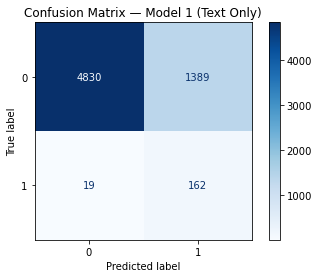

In [61]:
# Baseline Model Confusion Matrix
cm_m1 = confusion_matrix(y_test, pred)

plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_m1)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Model 1 (Text Only)")
plt.show()

#### **Baseline Model Interpretation**

The baseline model uses only textual features.

Observations:
 - The model correctly identifies 90% of suspicious reviews.
 - Only 10% of reviews predicted as suspicious are actually suspicious (162).
 - The model has good ranking ability. It can separate suspicious from non-suspicious reasonably well(86%).
 - The relatively low PR-AUC (11%) suggests that precision remains limited, motivating the inclusion of behavioural features.


This suggests that text alone is insufficient for detecting suspicious reviews.

This motivates adding behavioural and structural features.

### 5.2 Second Model (Text + Behavioural Features + Sentiment features)

In [40]:
# Columns
text_col = "text_norm"
num_cols = ["rating","thumbs_up", "is_code_mixed", "is_sheng_like",
    "word_count", "emoji_count", "exclamation_count", "sent_score_norm", "rating_scaled",
    "rating_sentiment_mismatch", "abs_sentiment_strength"]

# preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9), text_col),
        ("num", StandardScaler(), num_cols),
    ])

# Instantiate model2
model2 = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# fit
model2.fit(X_train, y_train)

# predict
proba2 = model2.predict_proba(X_test)[:, 1] #probability of suspicious class
pred2  = (proba2 >= 0.50).astype(int) #predicted labels 

print("MODEL 2 REPORT (threshold=0.50)")
print(classification_report(y_test, pred2, digits=2))
print("ROC-AUC:", round(roc_auc_score(y_test, proba2),2))
print("PR-AUC :", round(average_precision_score(y_test, proba2),2))

MODEL 2 REPORT (threshold=0.50)
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      6219
           1       0.11      0.92      0.20       181

    accuracy                           0.79      6400
   macro avg       0.56      0.85      0.54      6400
weighted avg       0.97      0.79      0.86      6400

ROC-AUC: 0.91
PR-AUC : 0.39


#### **Second Model Interpretation**
Observations:

 - The model correctly identifies 92% of suspicious reviews (very high recall).
 - Only 11% of reviews predicted as suspicious are actually suspicious (low precision).
 - The model demonstrates strong ranking ability, with a ROC-AUC of 0.91, indicating excellent class separation.
 - The PR-AUC improves significantly to 0.39, compared to 0.11 in the baseline model.

The substantial increase in PR-AUC (from 0.11 to 0.39) shows that:
 - Behavioural and structural features meaningfully improve the model’s ability to rank suspicious reviews higher.
 - The model is far more effective at distinguishing suspicious reviews from normal ones compared to text-only features.
 - However, at a 0.50 threshold, the model still produces many false positives due to the severe class imbalance.

#### 5.3 Third Model (Optimized Threshold)
Using the default 0.5 probability threshold may not be optimal for imbalanced fraud detection.

The threshold was adjusted to prioritize higher precision.

In [41]:
# Threshold optimization to get best threshold
precision, recall, thresholds = precision_recall_curve(y_test, proba2)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)

Best threshold: 0.9555479573524012


In [42]:
# The 2nd model with the optimized threshold to improve model performance
# Instantiate model2
model3 = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state = 42))
])

# fit
model3.fit(X_train, y_train)

proba3 = model3.predict_proba(X_test)[:, 1] #probability of suspicious class
pred3  = (proba3 >= 0.95).astype(int) #predicted labels 

print("MODEL 3 REPORT (threshold=0.95)")
print(classification_report(y_test, pred3, digits=2))
print("ROC-AUC:", round(roc_auc_score(y_test, proba3),2))
print("PR-AUC :", round(average_precision_score(y_test, proba3),2))

MODEL 3 REPORT (threshold=0.95)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6219
           1       0.83      0.30      0.45       181

    accuracy                           0.98      6400
   macro avg       0.91      0.65      0.72      6400
weighted avg       0.98      0.98      0.97      6400

ROC-AUC: 0.91
PR-AUC : 0.39


<Figure size 360x360 with 0 Axes>

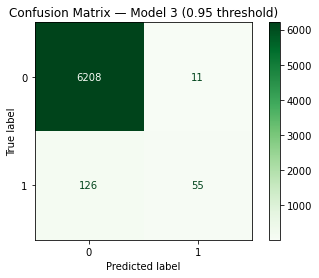

In [60]:
# Model 3 Confusion Matrix
cm_m3 = confusion_matrix(y_test, pred3)

plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_m3)
disp.plot(cmap="Greens")
plt.title("Confusion Matrix — Model 3 (0.95 threshold)")
plt.show()

Observations:

 - The model correctly identifies 30% of suspicious reviews (moderate recall).
 - 83% of reviews predicted as suspicious are actually suspicious (very high precision).
 - The model maintains strong ranking ability, with a ROC-AUC of 0.91.
 - The PR-AUC remains 0.39, indicating strong overall precision–recall performance across thresholds.

This demonstrates that:
 - Suspicious reviews are concentrated in the extreme high-probability region.
 - The model has strong discriminatory power.
 - Threshold selection directly controls the trade-off between precision and recall.
 - ROC-AUC and PR-AUC remain unchanged because they measure ranking performance, not a specific decision threshold.


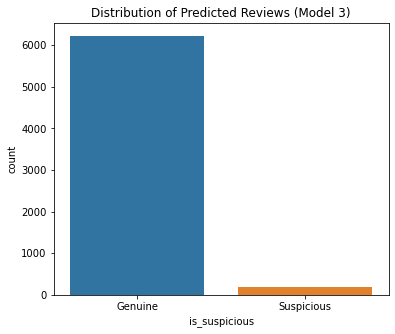

In [ ]:
# Distribution Plot of predicted reviews
labels = pd.Series(y_test).map({0: "Genuine", 1: "Suspicious"})

plt.figure(figsize=(6,5))
sns.countplot(x=labels)
plt.title("Distribution of Predicted Reviews (Model 3)")
plt.show()

The majority of reviews are predicted as Genuine. A smaller portion is flagged as Suspicious. This reflects the expected class imbalance in real-world review data, where most reviews are legitimate.


The model does not over-flag reviews as suspicious. Only a manageable subset of reviews would require manual moderation. The prediction threshold ensures that only high-risk reviews are flagged.

This distribution suggests the model is selective rather than aggressive.
It can help moderation teams focus their attention on a smaller, high-risk subset of reviews instead of reviewing all submissions.

#### 5.4 Model Comparison
A dataframe comparing the metrics for the 3 models.

In [43]:

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def get_metrics(y_true, pred, proba):
    return [
        accuracy_score(y_true, pred),
        precision_score(y_true, pred),
        recall_score(y_true, pred),
        f1_score(y_true, pred),
        roc_auc_score(y_true, proba),
        average_precision_score(y_true, proba)
    ]

comparison = pd.DataFrame(
    [
        get_metrics(y_test, pred, proba),
        get_metrics(y_test, pred2, proba2),
        get_metrics(y_test, pred3, proba3)
    ],
    columns=["Accuracy", "Precision (Suspicious)", "Recall (Suspicious)",
             "F1 (Suspicious)", "ROC-AUC", "PR-AUC"],
    index=["Baseline Model", "Model 2", "Model 3"]
)

comparison.round(2)

,Accuracy,Precision (Suspicious),Recall (Suspicious),F1 (Suspicious),ROC-AUC,PR-AUC
Baseline Model,0.78,0.10,0.90,0.19,0.86,0.11
Model 2,0.79,0.11,0.92,0.20,0.91,0.39
Model 3,0.98,0.83,0.30,0.45,0.91,0.39


#### **Interpretation**

Model 3 (hybrid text + behavioural features with optimized threshold) provides the most practical and statistically balanced solution for suspicious review detection.
It achieves:
 - High precision (0.83)
 - Best F1-score (0.45)
 - Strong ranking ability (ROC-AUC 0.91, PR-AUC 0.39)

Therefore, Model 3 represents the most effective and deployable model among the evaluated models.

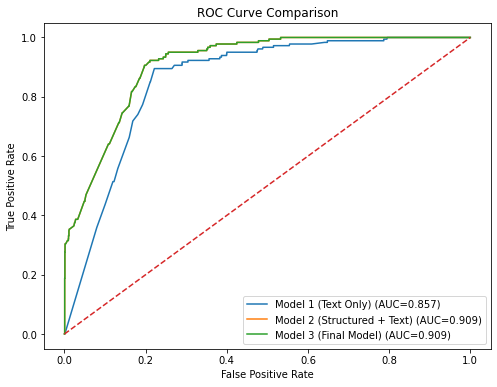

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
models = {
    "Model 1 (Text Only)": (baseline, X_test_text),
    "Model 2 (Structured + Text)": (model2, X_test),
    "Model 3 (Final Model)": (model3, X_test)
}

for name, (model, X_data) in models.items():
    probs = model.predict_proba(X_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

#### **Interpretation**
- Model 2 and Model 3 significantly outperform Model 1. Adding engineered features improved separability.
- Model 1 (text-only baseline) performs reasonably well, but lacks the additional predictive power from structured features.
- Model 2 and Model 3 show nearly identical ROC curves, meaning they separate suspicious vs genuine reviews equally well overall.


Feature engineering meaningfully improved model discrimination ability.

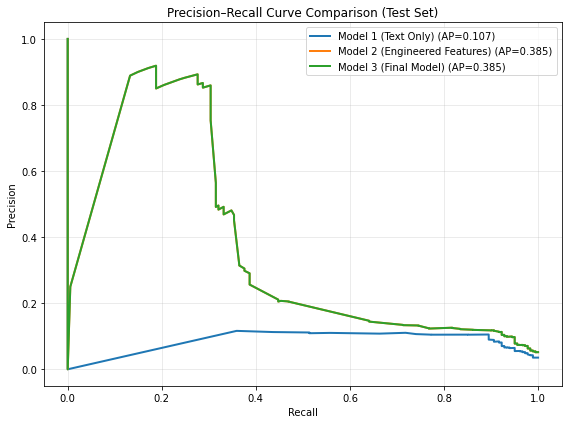

In [ ]:
# Precision-Recall Curves
plt.figure(figsize=(8,6))

models = {
    "Model 1 (Text Only)": (baseline, X_test_text),
    "Model 2 (Engineered Features)": (model2, X_test),
    "Model 3 (Final Model)": (model3, X_test)
}

for name, (model, X_data) in models.items():
    probs = model.predict_proba(X_data)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)

    plt.plot(recall, precision, linewidth=2, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.grid(alpha=0.3)
plt.legend(loc=1)
plt.tight_layout()

plt.show()

#### **Interpretation**
Model 1 performs poorly on precision–recall. Models 2 and 3 show dramatically improved precision at higher recall levels.

Since suspicious review detection is typically an imbalanced classification problem, the Precision–Recall curve is more informative than ROC.


## 6. Conclusion, Limitations, and Recommendations

### 6.1 Conclusion

This project aimed to develop a robust machine learning framework for **suspicious review detection** using Google Play Store reviews for Safaricom and M-Pesa. The primary objective was to identify potentially suspicious or manipulative reviews using a combination of textual signals, behavioural indicators anomaly-based heuristics and to evaluate how effectively machine learning models can detect such patterns.

The study was guided by three core research objectives:

---

#### Research Objective 1:  
**To engineer textual and behavioural features can effectively capture suspicious review patterns.**

To address this objective, extensive feature engineering was performed beyond raw text modelling to develop text-based features and behavioural and anomaly features. These features were incorporated into a hybrid modelling pipeline combining TF-IDF text representations with scaled numerical features.

The improvement in **PR-AUC from 0.11 to 0.39** indicates substantially better ranking performance for suspicious reviews, especially under class imbalance. This confirms that suspicious behaviour is not captured by text alone, and structural and anomaly-based signals are critical.


#### Research Objective 2:  
**To construct a practical and defensible framework for labeling suspicious reviews in the absence of ground-truth fraud labels.**

Since verified fraud labels were unavailable, a heuristic weak-supervision approach was developed. A composite suspicion score was constructed using weighted signals:
- Sentiment–rating contradiction  
- Burst-day anomaly  
- Duplicate review behaviour  
- Emoji spam  
- Excessive exclamation usage  

Reviews with a score ≥ 3 were labeled as suspicious.

This structured scoring system ensured that suspicious labels were not assigned based on a single weak indicator but rather on multiple converging signals. The approach reflects realistic fraud-detection practices where behavioural anomalies are combined to increase confidence.

#### Research Objective 3:  
**To evaluate model performance and determine whether threshold optimization improves high-confidence suspicious review detection.**

Three model configurations were evaluated:

##### 1. Baseline Model (TF-IDF only, threshold = 0.50)
- Suspicious Precision: 0.10  
- Suspicious Recall: 0.90  
- Suspicious F1-score: 0.19  
- ROC-AUC: 0.86  
- PR-AUC: 0.11  

This model achieved high recall but extremely low precision, meaning many non-suspicious reviews were incorrectly flagged.

##### 2. Hybrid Model (TF-IDF + behavioural features, threshold = 0.50)
- Suspicious Precision: 0.11  
- Suspicious Recall: 0.92  
- Suspicious F1-score: 0.20  
- ROC-AUC: 0.91  
- PR-AUC: 0.39  

The hybrid model significantly improved ranking ability and class separation but still suffered from low precision at the default classification threshold.


##### 3. Optimized Threshold Model (High-confidence threshold ≈ 0.95)
- Suspicious Precision: 0.83  
- Suspicious Recall: 0.30  
- Suspicious F1-score: 0.45  
- ROC-AUC: 0.91  
- PR-AUC: 0.39  
- Accuracy: 0.98  

By increasing the decision threshold to 0.95, the model dramatically improved precision from 0.11 to 0.83. Although recall dropped to 0.30, the flagged reviews became highly reliable.

Given that suspicious review detection systems often prioritize precision (to avoid falsely accusing genuine users), this threshold configuration is suitable for operational deployment.

### 6.2 Overall Conclusion

The project successfully developed a suspicious review detection framework that:
- Combines text modelling and behavioural anomaly detection  
- Operates effectively under class imbalance  
- Achieves strong ranking performance (ROC-AUC = 0.91)  
- Delivers high-confidence suspicious detection (Precision = 0.83 at optimized threshold)  

The final system is best suited as a **risk-flagging and prioritization tool**, rather than a fully automated fraud decision engine.


### 6.3 Limitations

Despite strong performance, several limitations exist:

1. **Weak Supervision Labels**  
   The suspicious labels are heuristic-based rather than ground-truth verified fraud labels. This introduces label noise and may affect model generalization.

2. **Class Imbalance**  
   Suspicious reviews represent a minority class, making metrics such as accuracy misleading. Although PR-AUC and F1 were used, imbalance remains a modelling challenge.

3. **Limited User-Level Behaviour Data**  
   The dataset does not include reviewer history, device identifiers, IP data, or cross-application behaviour, which are powerful fraud signals.

4. **Threshold Trade-Off**  
   High precision (0.83) comes at the cost of lower recall (0.30). The model intentionally misses some suspicious reviews to maintain reliability.

5. **Duplication Detection Rigidity**  
   The duplication threshold captures extreme repetition but may miss coordinated paraphrased campaigns.

6. **Sentiment Estimation Simplification**  
   Sentiment signals are rule-based and may misclassify sarcasm or nuanced complaints (complains with both positive and negative elements).

---

### 6.4 Recommendations

To improve and operationalize the system further, the following steps are recommended:
1. *Introduce Human Validation.* Create a manually reviewed subset of flagged and borderline reviews to:
- Improve label quality
- Measure true fraud detection performance
- Retrain the model using stronger ground truth
2. *Enhance Behavioural Aggregation.* If additional data becomes available, incorporate:
- Reviewer posting frequency
- Review bursts per user
- Cross-app duplicate behaviour
- Time-since-update anomalies

These features can significantly improve detection robustness.

---

### Final Statement

This project demonstrates that suspicious review detection can be effectively approached through a combination of text modelling, behavioural anomaly detection, and threshold optimization. While the current framework functions as a high-precision risk-flagging system, future improvements in labeling and behavioural aggregation can transform it into a more comprehensive fraud detection solution.

In [ ]:
import joblib
joblib.dump(model3, "model.joblib")
joblib.dump(0.95, "threshold.joblib")
print("Model Saved Successfully")

Model Saved Successfully
